# Fase 3: Data Preparation

# Imports y carga de datos

_Cargamos el DataFrame que ya limpiaste／entendiste en la fase anterior._

In [92]:
import pandas as pd
import numpy as np

In [93]:
path = '/Users/luissalamanca/Desktop/Fundamentos ML/csgo-analysis/data/01_raw/Anexo_ET_demo_round_traces_2022.csv'

df = pd.read_csv(path, sep=';', low_memory=False)

df_orig = df.copy()
print('Copia original cargada:', df_orig.shape)

def show(df, name):
    print(f"{name}: {df.shape}")

Copia original cargada: (79157, 30)


### Eliminación de columnas irrelevantes

In [94]:
df_prep_1 = df_orig.copy()
to_drop = [
    'Unnamed: 0', 'InternalTeamId',
    'TimeAlive', 'TravelledDistance',
    'TimeAlive_ns','TimeAlive_s_rel',
    'TravelledDistance_ns','TravelledDistance_s_abs'
]
df_prep_1 = df_prep_1.drop(columns=[c for c in to_drop if c in df_prep_1.columns])
show(df_prep_1, 'Después de drop irrelevantes')

Después de drop irrelevantes: (79157, 26)


### Manejo de valores faltantes en métricas de combate

In [95]:
# Imputar 0 en kills, assists, headshots, flank kills
df_prep_2 = df_prep_1.copy()
combat_cols = ['RoundKills','RoundAssists','RoundHeadshots','RoundFlankKills']
for c in combat_cols:
    df_prep_2[c] = df_prep_2[c].fillna(0).astype(int)
show(df_prep_2, 'Después de imputación de combat_cols')

Después de imputación de combat_cols: (79157, 26)


### Conversión de tipos básicos

In [97]:
df_prep_3 = df_prep_2.copy()
# RoundWinner a int, asegurando sin NA
df_prep_3['RoundWinner'] = (
    df_prep_3['RoundWinner']
      .map({True:1, False:0, 'True':1, 'False':0})
      .fillna(0)
      .astype(int)
)
# Map y Team como categorías
for cat in ['Map','Team']:
    df_prep_3[cat] = df_prep_3[cat].astype('category')
show(df_prep_3, 'Después de conversión de tipos')

Después de conversión de tipos: (79157, 26)


### Feature Engineering: tasa de headshots

In [14]:
df_prep_4 = df_prep_3.copy()
def calc_hs_rate(row):
    return row['RoundHeadshots'] / row['RoundKills'] if row['RoundKills'] > 0 else 0

df_prep_4['HeadshotRate'] = df_prep_4.apply(calc_hs_rate, axis=1)
df_prep_4['HighHeadshot'] = (df_prep_4['HeadshotRate'] >= 0.5).astype(int)
show(df_prep_4, 'Después de feature engineering')

Después de feature engineering: (79157, 28)


In [18]:


df_prep_4 = df_prep_3.copy()

df_prep_4['HeadshotRatio'] = np.where(
    df_prep_4['RoundKills'] > 0,
    df_prep_4['RoundHeadshots'] / df_prep_4['RoundKills'],
    0
)


df_prep_4['HighHeadshotRate'] = (df_prep_4['HeadshotRatio'] >= 0.5).astype(int)


show(df_prep_4, 'Después de crear HeadshotRatio y HighHeadshotRate')


df_prep_4[['RoundKills', 'RoundHeadshots', 'HeadshotRatio', 'HighHeadshotRate']].sample(10)


Después de crear HeadshotRatio y HighHeadshotRate: (79157, 28)


,RoundKills,RoundHeadshots,HeadshotRatio,HighHeadshotRate
36911,0,0,0.0,0
26794,1,0,0.0,0
46279,0,0,0.0,0
52194,0,0,0.0,0
33864,0,0,0.0,0
5756,0,0,0.0,0
49108,1,1,1.0,1
42413,0,0,0.0,0
53637,0,0,0.0,0
49516,2,2,1.0,1


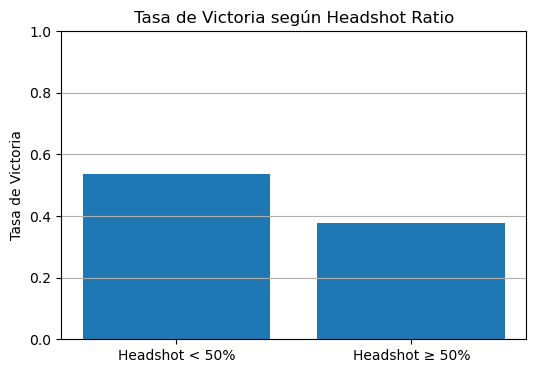

HighHeadshotRate
0    0.536737
1    0.377891
Name: RoundWinner, dtype: float64


In [19]:
import matplotlib.pyplot as plt

victory_rate = df_prep_4.groupby('HighHeadshotRate')['RoundWinner'].mean()

plt.figure(figsize=(6,4))
plt.bar(['Headshot < 50%', 'Headshot ≥ 50%'], victory_rate.values)
plt.title('Tasa de Victoria según Headshot Ratio')
plt.ylabel('Tasa de Victoria')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

print(victory_rate)


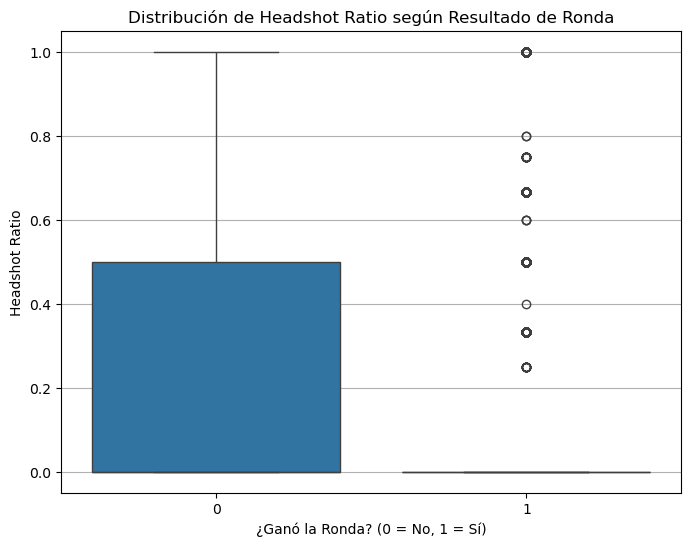

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.boxplot(
    x='RoundWinner',
    y='HeadshotRatio',
    data=df_prep_4
)
plt.title('Distribución de Headshot Ratio según Resultado de Ronda')
plt.xlabel('¿Ganó la Ronda? (0 = No, 1 = Sí)')
plt.ylabel('Headshot Ratio')
plt.grid(axis='y')

plt.show()


### Encoding y escalado

In [98]:
df_prep_5 = df_prep_4.copy()
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# — 1) One-hot encoding de mapa —
ohe = OneHotEncoder(sparse_output=False, drop='first')
map_ohe = ohe.fit_transform(df_prep_5[['Map']])
map_df = pd.DataFrame(
    map_ohe,
    index=df_prep_5.index,
    columns=ohe.get_feature_names_out(['Map'])
)
df_prep_5 = pd.concat([df_prep_5, map_df], axis=1).drop(columns=['Map'])

# — 2) Encoding para MatchWinner y Survived —
# Convertimos a 0/1 primero por seguridad
df_prep_5['MatchWinner'] = df_prep_5['MatchWinner'].map({True:1, False:0, 'True':1, 'False':0})
df_prep_5['Survived']    = df_prep_5['Survived'].map({True:1, False:0, 'True':1, 'False':0})

# Luego, si prefieres dummies (queda una sola columna _1 tras drop_first)
mw_d = pd.get_dummies(df_prep_5['MatchWinner'], prefix='MatchWon', drop_first=True)
sv_d = pd.get_dummies(df_prep_5['Survived'],    prefix='Survived', drop_first=True)

df_prep_5 = pd.concat([df_prep_5, mw_d, sv_d], axis=1).drop(columns=['MatchWinner','Survived'])

# — 3) Escalado de HeadshotRate —
df_prep_5['HeadshotRate'] = StandardScaler().fit_transform(
    df_prep_5[['HeadshotRate']]
)

# Visualizar forma final
show(df_prep_5, 'Después de encoding y escalado')

Después de encoding y escalado: (79157, 30)


### Guardado final

In [86]:
df_final = df_prep_5.copy()
df_final.to_csv('04_data_prepared.csv', index=False)
print('Guardado en 04_data_prepared.csv | shape:', df_final.shape)

Guardado en 04_data_prepared.csv | shape: (79157, 30)
